# Differentiable modeling dark matter halo assembly history

This notebook is intended to provide a few worked examples of vectorization and autodiff with JAX using the [Diffmah](https://astro.theoj.org/article/26991-a-differentiable-model-of-the-assembly-of-individual-and-populations-of-dark-matter-halos) model of dark matter halo growth. This the basic outline of what we will do in this notebook:


### Outline

1. Build a simple power-law type model of $M_{\rm halo}(t),$ the mass growth of a dark matter halo over time
2. Use `jax.grad` to compute $dM_{\rm halo}/dt$ from $M_{\rm halo}(t)$
3. Use `jax.vmap` to vectorize the calculation of the half-mass formation time, $t_{50\%},$ for a population of halos at a time
4. Implement our own gradient descent loop to derive best-fitting parameters approximating $M_{\rm halo}(t)$ of a simulated halo.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import jit as jjit

This simple sigmoid is a very useful function for building many kinds of models. We'll use it in our model of $M_{\rm halo}(t),$ so let's take a look at how the basic underlying parameters of the sigmoid change the behavior of the function.

In [2]:
@jjit
def _sigmoid(x, x0, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1.0 + jnp.exp(-k * (x - x0)))

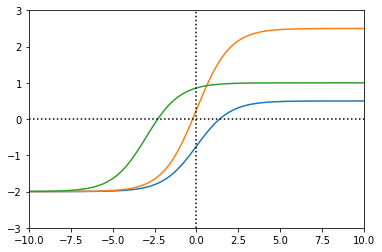

In [3]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-10, 10)
ylim = ax.set_ylim(-3, 3)

xarr = np.linspace(*xlim, 100)

# Plot a few example sigmoids
__=ax.plot(xarr, _sigmoid(xarr, 0, 1, -2, 0.5))
__=ax.plot(xarr, _sigmoid(xarr, 0, 1, -2, 2.5))
__=ax.plot(xarr, _sigmoid(xarr, -3, 1, -2, 1))

# make black dotted lines
__=ax.plot(xarr, np.zeros_like(xarr), ':', color='k')
__=ax.plot(np.zeros_like(xarr), np.linspace(*ylim, xarr.size), ':', color='k')

The asymptotic behavior at low- and high-$x$ is controlled by $y_{\rm lo}$ and $y_{\rm hi}$. The midpoint between these two asymptotic values is set by the $x_0$ parameter, and $k$ controls how quickly the sigmoid varies between the low- and high-$x$ limiting behavior.

### Diffmah model of $M_{\rm halo}(t)$

In the next cell, we'll implement the Diffmah model of halo mass assembly history, $M_{\rm halo}(t) = M_0\cdot (t/t_0)^{\alpha(t)},$ where the $t_0$ and $M_0$ are the present-day time and mass, and the power-law index $\alpha(t)$ smoothly rolls in time according to a sigmoid function.

In [4]:
MAH_K = 3.5

@jjit
def _power_law_index_vs_logt(logt, logtc, k, early, late):
    rolling_index = _sigmoid(logt, logtc, k, early, late)
    return rolling_index

@jjit
def _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late):
    """Kernel of the rolling power-law between halo mass and time."""
    rolling_index = _power_law_index_vs_logt(logt, logtc, k, early, late)
    log_mah = rolling_index * (logt - logt0) + logmp
    return log_mah

Now let's use this model to look at mass assembly histories for group-mass halos $M_{0}=10^{13}M_{\odot}$, choosing typical parameter values for halos with early, median, and late formation times. 

In [5]:
lgm0 = 13.0
T0 = 13.8
tarr = np.linspace(0.1, T0, 100)

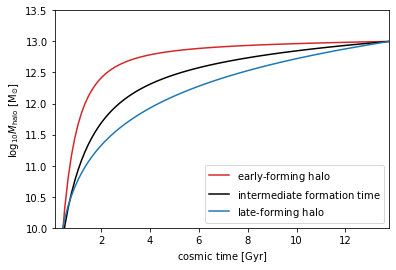

In [6]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

mred = u'#d62728'
mblue = u'#1f77b4'

early_diffmah = -0.1, MAH_K, 2.75, 0.2
log_mah_early = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *early_diffmah)
__=ax.plot(tarr, log_mah_early, color=mred, label=r'${\rm early}$-${\rm forming\ halo}$')

med_diffmah = 0.25, MAH_K, 2.25, 1.0
log_mah_med = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *med_diffmah)
__=ax.plot(tarr, log_mah_med, color='k', label=r'${\rm intermediate\ formation\ time}$')

late_diffmah = 1.5, MAH_K, 2.0, 1.9
log_mah_late = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *late_diffmah)
__=ax.plot(tarr, log_mah_late, color=mblue, label=r'${\rm late}$-${\rm forming\ halo}$')

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo}\ {\rm [M_{\odot}]}$')

## Using `jax.grad` to calculate $dM_{\rm halo}/dt$ 

The Diffmah model above directly parametrizes $M_{\rm halo}(t),$ and so we can use JAX to compute the time derivative of our model, which gives the history of halo mass accretion rate.

In the cells below, we'll use `jax.grad` to compute $dM_{\rm halo}/dt$ in two different ways: one in which we differentiate the function above that models $\log_{10}M_{\rm halo}(t),$ and a second one in which we differentiate $M_{\rm halo}(t).$ The only difference is that in the first case, we need to do a little extra calculus to account for an additional Jacobi factor of the derivative. The plot shows that these two methods agree, which just demonstrates that autodiff works as expected: when computing gradients, you can choose whether you want to propagate individual pieces of a derivative for yourself, or leave that up to autodiff.

In [7]:
from jax import grad
from jax import vmap


### First method in which we differentiate log10(Mh(t))

@jjit
def _rolling_plaw_vs_t(t_gyr, logt0, logmp, logtc, k, early, late):
    """Identical to _rolling_plaw_vs_logt but written as a function of linear time"""
    logt = jnp.log10(t_gyr)
    return _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late)

_d_log_mh_dt_scalar = jjit(grad(_rolling_plaw_vs_t, argnums=0))
_d_log_mh_dt = jjit(vmap(_d_log_mh_dt_scalar, in_axes=(0, *[None] * 6)))


@jjit
def _get_dmhdt(t_gyr, logt0, logmp, logtc, k, early, late):
    """Calculate dMh/dt in units of Msun/yr
    
    We use jax.grad to calculate d/dt(log10(Mh(t))) = log10(e)*(dMh/dt)/Mh
    To get dMh/dt from the quantity returned by jax.grad,
    we multiply by compensating factor Mh(t)/log10(e), and convert Gyr-->yr.

    """
    d_log_mh_dt = _d_log_mh_dt(t_gyr, logt0, logmp, logtc, k, early, late)
    log_mah = _rolling_plaw_vs_t(t_gyr, logt0, logmp, logtc, k, early, late)
    dmhdt = d_log_mh_dt * (10.0 ** (log_mah - 9.0)) / jnp.log10(jnp.e)
    return dmhdt


### Alternate method in which we differentiate Mh(t)

@jjit
def _mhalo_vs_t_kern(t_gyr, logt0, logmp, logtc, k, early, late):
    """Identical to _rolling_plaw_vs_logt
    but written as a function of linear time and returns Mh(t) instead of log10(Mh)"""
    logt = jnp.log10(t_gyr)
    return 10**_rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late)


_d_mh_dt_scalar = jjit(grad(_mhalo_vs_t_kern, argnums=0))
_d_mh_dt_vmap = jjit(vmap(_d_mh_dt_scalar, in_axes=(0, *[None] * 6)))


@jjit
def _get_dmhdt_alt(t_gyr, logt0, logmp, logtc, k, early, late):
    """Calculate dMh/dt in units of Msun/yr
    
    We use jax.grad to calculate d/dt(Mh(t))
    To get dMh/dt from the quantity returned by jax.grad,
    we only need to convert Gyr-->yr.

    """
    dmhdt_gyr = _d_mh_dt_vmap(t_gyr, logt0, logmp, logtc, k, early, late)
    dmhdt = dmhdt_gyr/1e9
    return dmhdt


In [8]:
dmhdt_early = _get_dmhdt(tarr, np.log10(T0), lgm0, *early_diffmah)
dmhdt_med = _get_dmhdt(tarr, np.log10(T0), lgm0, *med_diffmah)
dmhdt_late = _get_dmhdt(tarr, np.log10(T0), lgm0, *late_diffmah)

alt_dmhdt_early = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *early_diffmah)
alt_dmhdt_med = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *med_diffmah)
alt_dmhdt_late = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *late_diffmah)

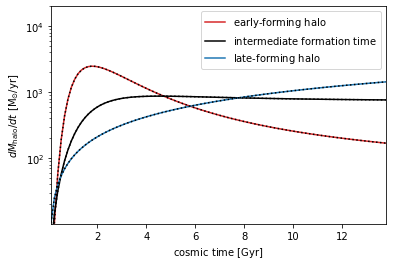

In [11]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
ylim = ax.set_ylim(10.1, 2e4)
xlim = ax.set_xlim(0.1, T0)

__=ax.plot(tarr, dmhdt_early, color=mred, label=r'${\rm early}$-${\rm forming\ halo}$')
__=ax.plot(tarr, dmhdt_med, color='k', label=r'${\rm intermediate\ formation\ time}$')
__=ax.plot(tarr, dmhdt_late, color=mblue, label=r'${\rm late}$-${\rm forming\ halo}$')

# Verify that grad computed through alternate means gives identical results
__=ax.plot(tarr, alt_dmhdt_early, ':', color='k')
__=ax.plot(tarr, alt_dmhdt_med, ':', color='k')
__=ax.plot(tarr, alt_dmhdt_late, ':', color='k')

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$dM_{\rm halo}/dt\ {\rm [M_{\odot}/yr]}$')

## Vectorized calculations on a population of halos

We'll use the DiffmahPop to generate a population of Diffmah parameters and assembly histories. And then we'll use `jax.vmap` to calculate the formation time of each halo, defined as the time the halo mass first exceeds $50\%$ of its present-day mass, so that $M_{\rm halo}(t_{50\%}) \equiv \frac{1}{2}M_0.$

In [12]:
!pip install diffmah

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffmah: filename=diffmah-0.4.0-py3-none-any.whl size=108507 sha256=ed6dcb745a512229c1888a36bb31a3a97b09259785c8a32fbead74361d61e6c2
  Stored in directory: /root/.cache/pip/wheels/27/7f/4a/6dffc0413101ce20a7aa2532262666b2484c0533082725ed7b
Successfully built diffmah


In [13]:
from diffmah.monte_carlo_halo_population import mc_halo_population

# Generate assembly histories of a sample of halos of the same present-day mass
halopop = mc_halo_population(tarr, T0, lgm0+np.zeros(10_000))

# halopop is a namedtuple with the following fields
print(halopop._fields)

('dmhdt', 'log_mah', 'early_index', 'late_index', 'lgtc', 'mah_type')


First let's just visually inspect a few different halos in the generated population.

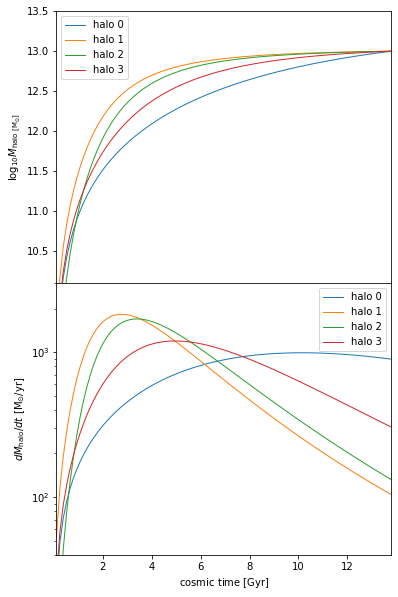

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
fig.subplots_adjust(hspace=0)  #  smash left and right plots

ylim = ax0.set_ylim(lgm0-2.9, lgm0+0.5)
ylim = ax1.set_ylim(40, 3_000)
xlim = ax0.set_xlim(0.1, T0)
yscale = ax1.set_yscale('log')

for ihalo in range(4):
    __=ax0.plot(tarr, halopop.log_mah[ihalo, :], lw=1, label='halo {}'.format(ihalo))
    __=ax1.plot(tarr, halopop.dmhdt[ihalo, :], lw=1, label='halo {}'.format(ihalo))
    
xlabel = ax1.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax0.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')
ylabel = ax1.set_ylabel(r'$dM_{\rm halo}/dt\ [{\rm M_{\odot}/yr]}$')
leg = ax0.legend()
leg = ax1.legend()

### Calculating halo formation time $t_{\rm form}$

Now let's calculate the _formation time_, $t_{\rm form},$ of one of the halos in our population, where we define $t_{\rm form}$ as the time at which the halo first reaches some fraction of its present-day mass. Different choices for this fraction correspond to different definitions of halo formation time. The cell below calculates $t_{\rm form}$ by lookup-table inversion, and the next plot illustrates a few different examples for the first halo in our population.

In [15]:
@jjit
def _compute_lgtform_kern(lgtarr, lgmarr, tform_frac):
    """Calculate the time the halo reaches the input fraction of its final mass """
    lgm_form = jnp.log10(tform_frac*10**lgmarr[-1])
    lgtform = jnp.interp(lgm_form, lgmarr, lgtarr)
    return lgtform

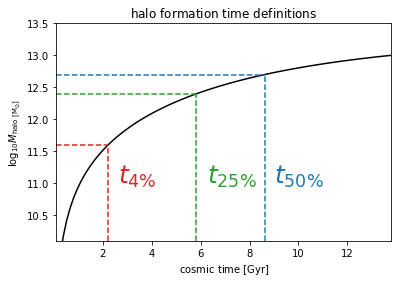

In [16]:
ihalo = 0


fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-2.9, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

__=ax.plot(tarr, halopop.log_mah[ihalo, :], color='k')

tform_p = 0.5
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color=mblue)
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color=mblue)

mgreen = u'#2ca02c'
tform_p = 0.25
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color=mgreen)
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color=mgreen)

tform_p = 0.04
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color=mred)
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color=mred)


a, b = 9, 11
__=ax.annotate(r'$t_{\rm 50\%}$', xy=(a, b), xytext=(a, b), size=25, color=mblue)

a = 6.25
__=ax.annotate(r'$t_{\rm 25\%}$', xy=(a, b), xytext=(a, b), size=25, color=mgreen)

a = 2.6
__=ax.annotate(r'$t_{\rm 4\%}$', xy=(a, b), xytext=(a, b), size=25, color=mred)

ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
title = ax.set_title(r'${\rm halo\ formation\ time\ definitions}$')

### Calculating $t_{\rm form}$ for a halo population with jax.vmap

Now let's calculate $t_{\rm form}$ for each of the mass assembly histories (MAHs) in our halo population. We could do this in a simple pure-python loop, but we can do this more efficiently by using the `jax.vmap`, which will transform  `_compute_lgtform_kern` into a function that accepts a _matrix_ of MAHs, and returns an array of $t_{\rm form}.$


#### Using the `in_axes` argument of `jax.vmap` to vectorize a multi-variable function
The `_compute_lgtform_kern` function accepts $N_{\rm args}=3$ arguments: `lgtarr`, `lgmarr`, and `tform_frac`. Let's say we want to calculate $t_{50\%}$ for every halo (so that `tform_frac=0.5`), and that we'll use the same time array `lgtarr` for the specification of every halo's MAH, so that we only want to vectorize over the second argument, `lgmarr`. We convey this information to `jax.vmap` via the `in_axes` argument, which should contain a length $N_{\rm args}$ tuple, using `None` and `0` for non-vectorized and vectorized arguments, respectively. In the cells below, we'll use `jax.vmap` to do this form of the calculation three separate times: one each for $t_{50\%}$, $t_{25\%}$, and $t_{4\%}$, and then plot a histogram of the results.

In [17]:
from jax import vmap

_a = (None, 0, None) # Use the same tform definition for many halos at once
_compute_lgtform_vmap_halopop = jjit(vmap(_compute_lgtform_kern, in_axes=_a))

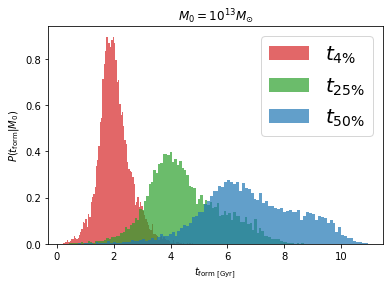

In [18]:
tform_p50 = 10**_compute_lgtform_vmap_halopop(np.log10(tarr), halopop.log_mah, 0.5)
tform_p25 = 10**_compute_lgtform_vmap_halopop(np.log10(tarr), halopop.log_mah, 0.25)
tform_p04 = 10**_compute_lgtform_vmap_halopop(np.log10(tarr), halopop.log_mah, 0.04)

fig, ax = plt.subplots(1, 1)
__=ax.hist(tform_p04, bins=100, density=True, alpha=0.7, color=mred, label=r'$t_{\rm 4\%}$')
__=ax.hist(tform_p25, bins=100, density=True, alpha=0.7, color=mgreen, label=r'$t_{\rm 25\%}$')
__=ax.hist(tform_p50, bins=100, density=True, alpha=0.7, color=mblue, label=r'$t_{\rm 50\%}$')
leg = ax.legend(fontsize=20)

xlabel = ax.set_xlabel(r'$t_{\rm form\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$P(t_{\rm form}\vert M_0)$')
title = ax.set_title(r'$M_0=10^{13}M_{\odot}$')

#### Using `jax.vmap` again to vectorize over calculations of a few different $t_{\rm form}$ definitions

In the code above, we created a version of `_compute_lgtform_kern` that computed some particular value of $t_{\rm form}$ for every halo in the population. And in order to make our histogram plot of $t_{50\%}$, $t_{25\%}$, and $t_{4\%}$, we repeated that calculation three separate times. This next cell shows how we can use `jax.vmap` again to create a version that accepts an array input for `tform_frac`.

In [19]:
_b = (None, None, 0) # Vectorize the tform definition
_compute_lgtform_vmap_tformdef = jjit(vmap(_compute_lgtform_vmap_halopop, in_axes=_b))

In [20]:
tform_frac_arr = np.array((0.5, 0.25, 0.04))
tform_collection = 10**_compute_lgtform_vmap_tformdef(np.log10(tarr), halopop.log_mah, tform_frac_arr)
tform_collection.shape

(3, 10000)

In [21]:
assert np.allclose(tform_p50, tform_collection[0, :], rtol=1e-5)
assert np.allclose(tform_p25, tform_collection[1, :], rtol=1e-5)
assert np.allclose(tform_p04, tform_collection[2, :], rtol=1e-5)

#### More `jax.vmap` practice: calculate $t_{\rm form}$ for every halo, where each halo gets its own individual $t_{\rm form}$ definition

In the code above, we vectorized `_compute_lgtform_kern` to give us a function that calculated $t_{\rm form}$ for every halo, and for a few different values of $t_{\rm form}.$ Let's use `jax.vmap` to give us a function that computes $t_{\rm form}$ according to each individual halo's value of `tform_frac`. In this situation, we are vectorizing over two arguments at once, and so we set `in_axes=(None, 0, 0)`. 

In [22]:
_c = (None, 0, 0)
_compute_lgtform_vmap = jjit(vmap(_compute_lgtform_kern, in_axes=_c))

n_halos = halopop.log_mah.shape[0]
tform_frac_arr = np.random.uniform(0, 1, n_halos)
tform_collection = 10**_compute_lgtform_vmap(np.log10(tarr), halopop.log_mah, tform_frac_arr)
tform_collection.shape

(10000,)

Let's verify that results with this new function agree with our previous one when passing in an array of all the same values:

In [23]:
tform_def = 0.5
tform_frac_arr = np.zeros(halopop.log_mah.shape[0]) + tform_def
t50_scalar = 10**_compute_lgtform_vmap_halopop(np.log10(tarr), halopop.log_mah, tform_def)
t50_vmap = 10**_compute_lgtform_vmap(np.log10(tarr), halopop.log_mah, tform_frac_arr)

assert np.allclose(t50_vmap, t50_scalar, rtol=1e-5)

## Examine the MAHs of the generated populuation

Let's sort our MC-generated halo population according to $t_{\rm form},$ and visually inspect the typical assembly histories of the earliest- and latest-forming halos.

In [24]:
indx_sorted_tform_p50 = np.argsort(np.array(tform_p50))

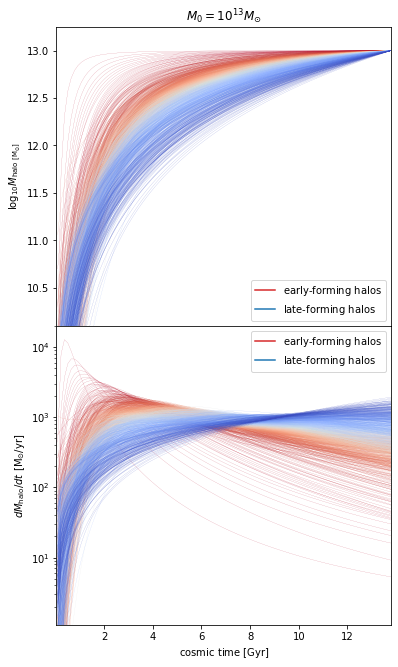

In [25]:
from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm early}$-${\rm forming\ halos}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm late}$-${\rm forming\ halos}$')

import matplotlib.cm as cm
colors=cm.coolwarm(np.linspace(1,0,halopop.log_mah.shape[0])) # red first


fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 11), sharex=True)
fig.subplots_adjust(hspace=0)  #  smash left and right plots
ylim = ax0.set_ylim(lgm0-2.9, lgm0+0.25)
xlim = ax0.set_xlim(0.05, T0)
yscale = ax1.set_yscale('log')
ylim = ax1.set_ylim(1.1, 2e4)

title = ax0.set_title(r'$M_0=10^{13}M_{\odot}$')
ylabel = ax0.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')

n_skip = 10
for i in np.arange(halopop.log_mah.shape[0])[::n_skip]:
    __=ax0.plot(tarr, halopop.log_mah[indx_sorted_tform_p50[i], :], color=colors[i], lw=0.1)
leg=ax0.legend(handles=[red_line, blue_line])

    
for i in np.arange(halopop.log_mah.shape[0])[::n_skip]:
    __=ax1.plot(tarr, halopop.dmhdt[indx_sorted_tform_p50[i], :], color=colors[i], lw=0.1)
leg1=ax1.legend(handles=[red_line, blue_line])
 
ylabel = ax1.set_ylabel(r'$dM_{\rm halo}/dt\ [{\rm M_{\odot}/yr]}$')
xlabel = ax1.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')

## Optimizing model parameters with gradient descent

Let's use the parametric model defined above to approximate the MAH of a simulated halo. For simplicity, I have just dumped the MAH of a randomly selected halo of mass $M_0\approx10^{13}M_{\odot}$ taken from the Bolshoi-P simulation. So in the plot below let's just examine this simulated MAH against the backdrop of the range of assembly histories in our generated population.

In [26]:
log_mah_target = np.array(
    [10.9, 10.99, 11.08, 11.14, 11.43, 11.61, 11.69, 11.76, 11.8, 
     11.85, 11.93, 12.01, 12.07, 12.2, 12.28, 12.38, 12.41, 12.43, 
     12.44, 12.46, 12.55, 12.59, 12.61, 12.63, 12.66, 12.77, 12.81, 
     12.87, 12.89, 12.9, 12.91, 12.91, 12.91, 12.93, 12.95, 12.97, 12.99])

t_target = np.array([1.02, 1.23, 1.45, 1.69, 1.93, 2.19, 2.45, 2.72, 3.01, 
                    3.29, 3.59, 3.89, 4.2, 4.51, 4.83, 5.15, 5.47, 5.8, 
                    6.13, 6.46, 6.79, 7.13, 7.46, 7.79, 8.13, 8.46, 8.8, 
                    9.25, 9.74, 10.23, 10.72, 11.2, 11.67, 12.14, 12.6, 13.05, 13.5])

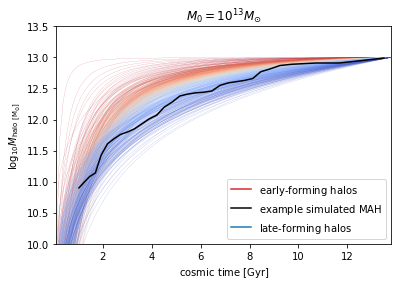

In [27]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

import matplotlib.cm as cm
colors=cm.coolwarm(np.linspace(1,0,halopop.log_mah.shape[0])) # red first

n_skip = 20
for i in np.arange(halopop.log_mah.shape[0])[::n_skip]:
    __=ax.plot(tarr, halopop.log_mah[indx_sorted_tform_p50[i], :], color=colors[i], lw=0.1)

    
__=ax.plot(t_target, log_mah_target, color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')
title = ax.set_title(r'$M_0=10^{13}M_{\odot}$')

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm early}$-${\rm forming\ halos}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm late}$-${\rm forming\ halos}$')
black_line=mlines.Line2D([],[],ls='-',c='k',label=r'${\rm example\ simulated\ MAH}$')

leg=ax.legend(handles=[red_line, black_line, blue_line])

## Setting up gradient descent

The cell below defines the loss function that we will try to minimize in order to identify a best-fitting Diffmah approximation to the simulated halo. For our loss we use the MSE of the logarithmic difference between the predicted and target MAH. In our fits, we'll hold fixed the present-day mass $M_0$ and also the `mah_k` parameter, and run a 3-parameter fit for parameters $\theta=\{\log_{10}(\tau_{\rm c}), \alpha_{\rm early}, \alpha_{\rm late}\}.$

In [30]:
@jjit
def _mse(preds, targets):
    diffs = preds - targets
    return jnp.mean(diffs**2)

@jjit
def _loss_func(params, loss_data):
    t_pred, log_mah_target, lgt0, logm0, mah_k = loss_data
    lgtc, early, late = params
    log_mah_pred = _rolling_plaw_vs_t(t_pred, lgt0, logm0, lgtc, mah_k, early, late)
    return _mse(log_mah_pred, log_mah_target)

#### Choose an initial guess `p_init`

Then collect the values that should be packed into `loss_data`, and evaluate the loss function.

In [31]:
lgtc_init, early_init, late_init = 0.25, 2.5, 0.5
p_init = jnp.array((lgtc_init, early_init, late_init))

In [32]:
loss_data = (t_target, log_mah_target, np.log10(T0), lgm0, MAH_K)
_loss_func(p_init, loss_data)

DeviceArray(0.07512797, dtype=float32)

### Use value_and_grad convenience function

The `jax.value_and_grad` is a convenient function to use in gradient descent exercises. It returns a scalar value of the loss and a length-$N_{\rm params}$ array for the gradient of the loss w/r/t $\theta.$ 

In [33]:
from jax import value_and_grad
_loss_and_grad_func = jjit(value_and_grad(_loss_func, argnums=0))
_loss_and_grad_func(p_init, loss_data)

(DeviceArray(0.07512797, dtype=float32),
 DeviceArray([-0.32934403, -0.07682967, -0.16427392], dtype=float32))

### Descending our own gradient

At this point we could make use of any number of very efficient optimization algorithms to identify a best-fitting set of parameters. Modern algorithms such as Adam are able to leverage accurate gradient information to optimize million-dimensional parameter spaces. [This blog post by Sebastian Ruder](https://www.ruder.io/optimizing-gradient-descent/) gives a nice summary of many different variations of gradient descent. Here we only have a three-dimensional model, and so we can get away with a very simple descent down the gradient of our loss using a fixed learning rate.

In [34]:
learning_rate = 0.1
n_steps = 300

p = np.copy(p_init)
collector = []
for istep in range(n_steps):
    loss, grads = _loss_and_grad_func(p, loss_data)
    p = p - learning_rate*grads
    collector.append((loss, p))

#### Inspect the loss curve

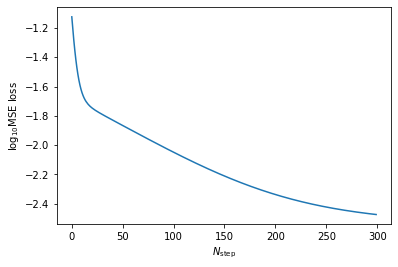

In [35]:
p_best = np.array(collector[-1][1])
lgloss_history = np.log10(np.array([x[0] for x in collector]))

fig, ax = plt.subplots(1, 1)
__=ax.plot(lgloss_history)

xlabel = ax.set_xlabel(r'$N_{\rm step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm MSE\ loss}$')

#### Check accuracy of best-fit model

In [36]:
log_mah_best = _rolling_plaw_vs_t(tarr, np.log10(T0), lgm0, p_best[0], MAH_K, p_best[1], p_best[2])
log_mah_init = _rolling_plaw_vs_t(tarr, np.log10(T0), lgm0, p_init[0], MAH_K, p_init[1], p_init[2])

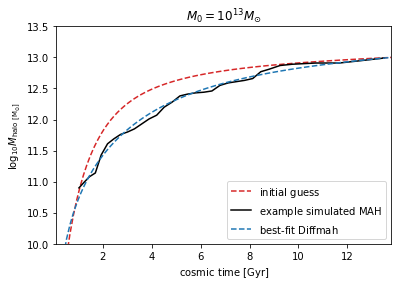

In [37]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)
    
__=ax.plot(tarr, log_mah_init, '--', color=mred, label=r'${\rm initial\ guess}$')
__=ax.plot(t_target, log_mah_target, color='k', label=r'${\rm example\ simulated\ MAH}$')
__=ax.plot(tarr, log_mah_best, '--', color=mblue, label=r'${\rm best}$-${\rm fit\ Diffmah}$')
leg = ax.legend()

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')
title = ax.set_title(r'$M_0=10^{13}M_{\odot}$')

#### Inspect how model accuracy improves over the course of the gradient descent

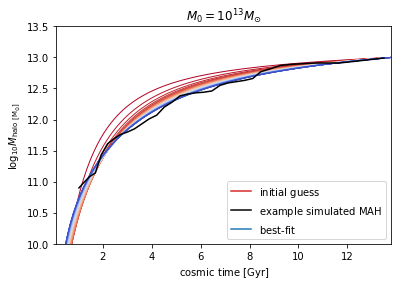

In [38]:
import matplotlib.cm as cm

colors=cm.coolwarm(np.linspace(1, 0, n_steps)) # red first


fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

n_skip = 5
for ip, (loss, p) in enumerate(collector[::n_skip]):
    log_mah_pred = _rolling_plaw_vs_t(tarr, np.log10(T0), lgm0, p[0], MAH_K, p[1], p[2])
    __=ax.plot(tarr, log_mah_pred, color=colors[::n_skip][ip], lw=1)

__=ax.plot(t_target, log_mah_target, '-', color='k')
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo\ [M_{\odot}]}$')
title = ax.set_title(r'$M_0=10^{13}M_{\odot}$')

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm initial\ guess}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm best}$-${\rm fit}$')
leg=ax.legend(handles=[red_line, black_line, blue_line])